## Análise de dados de estudantes do ensino médio da cidade de Nova York

O SAT, ou Scholastic Aptitude Test, é um teste que os alunos do ensino médio nos Estados Unidos fazem todos os anos. O SAT tem três seções, cada uma das quais vale no máximo 800 pontos. As faculdades utilizam o SAT para determinar quais alunos devem ser admitidos. As notas médias altas no SAT são geralmente indicativas de uma boa escola.

A cidade de Nova Iorque publicou dados sobre as notas dos alunos no SAT por escola secundária, juntamente com conjuntos de dados demográficos adicionais.

Considerando que Nova Iorque tem uma população imigrante significativa e é muito diversificada, adotei como objetivo desse projeto entender se a comparação de fatores demográficos como raça, renda e gênero com os resultados do SAT seria uma boa maneira de determinar se o SAT é um teste justo. Por exemplo, se certos grupos raciais obtiverem um desempenho melhor no SAT, isto poderia ser usado como evidência para se afirmar que o SAT é um exame injusto.

### Lendo os dados em .csv

In [23]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot
matplotlib.style.use('fivethirtyeight')  
from mpl_toolkits.basemap import Basemap


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Explorando os dados do SAT

O principal dataset que nos interessa é o do SAT. Este contém informações sobre os resultados do SAT de cada escola de ensino fundamental de Nova Iorque. O meu objetivo é correlacionar itens deste dataset com itens de outros conjuntos de dados.

Vou explorar os dados do conjunto sat_results para ver quais informações podem ser extraídas a partir dos dados. Explorar este conjunto de dados nos permitirá entender um pouco mais a respeito da estrutura dos dados, o que facilitará a análise.

### Lendo os dados em .txt

In [24]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

In [25]:
data["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


A partir da análise dos dados, pude fazer algumas observações:

- O DBN parece ser um código de identificação único para cada escola.
Ao observar as primeiras linhas, tenho apenas dados sobre as escolas de ensino fundamental.
- Há uma única linha para cada escola, portanto cada DBN representa um dado único no conjunto de dados do SAT.
- Para facilitar a análise, eu vou combinar em uma única coluna as três colunas que contém os resultados do SAT -- SAT Critical Reading Avg., Score SAT Math Avg. Score, e SAT Writing Avg.

### Explorando os outros dados

Dadas estas observações, explorarei os outros conjuntos de dados para saber a melhor forma de combinar os conjuntos de dados.

In [26]:
for k in data:
    print(data[k].head())

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7

### Lendo os dados das pesquisas

A partir das primeiras linhas de cada conjunto de dados, observei algumas coisas:

- Cada conjunto de dados parece ter uma coluna DBN ou a informação necessária para criar uma coluna DBN, de modo que é a partir deste dado que vamos combinar nossos conjuntos de dados e gerar um só dataset. Combinarei linhas de diferentes conjuntos de dados que tenham o mesmo DBN e também suas colunas. 
- Alguns campos parecem interessantes para mapearmos, especialmente o Location 1, que contém coordenadas em meio a diversos outros termos armazenados em uma string. 
- Alguns dos conjuntos de dados parecem ter várias linhas para cada escola (DBNs repetidos), o que significa que teremos que realizar um pré-processamento de modo a garantir que o DBN seja um valor único único dentro de cada conjunto de dados. Se eu não fizer isso, os dados repetidos causarão problemas quando combinarmos os conjuntos de dados, pois poderei estar fundindo duas linhas de um conjunto de dados com uma linha em outro. 

Antes combinar os conjuntos de dados, deverei garantir que tenhamos todos os dados que queremos unificar. Mencionei os dados da pesquisa, survey_all.txt e survey_d75.txt, anteriormente, mas não fiz a leitura destes, pois estavam em um formato um pouco mais complexo.

Os arquivos possuem separação de dados por tabulação, e são codificados com a codificação Windows-1252. A codificação define como o conteúdo de um arquivo é armazenado em formato binário. Os codificadores mais comuns são UTF-8 e ASCII.

Precisarei especificar a codificação e delimitação para a função read_csv do Pandas, a fim de garantir que os arquivos das pesquisas sejam lidos corretamente.

Após ler nos dados das pesquisaa, vou combiná-los em um único Dataframe. Posso fazer isso utilizando a função Pandas concat.

In [27]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


### Realizando a limpeza de dados de três colunas

Há dois fatos que podemos observar nos dados:

- Há mais de 2000 colunas de dados, das quais quase todas não vamos precisar. Precisaremos filtrá-las para remover colunas e facilitar o trabalho. Quanto menos colunas, mais fácil será trabalhar com o dataframe e encontrar correlações.
- Os dados da pesquisa tem uma coluna chamada dbn que vamos renomear para DBN, de modo a alcançar um grau de consistência com os outros conjuntos de dados.

Precisaremos filtrar as colunas de modo a remover aquelas que não precisamos. Baseado em nossas observações, as colunas abaixo parecem as mais relevantes para a nossa análise:

["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

Essas colunas nos darão informações agregadas sobre como pais, professores e alunos se sentem a respeito da segurança no ambiente escolar, performance acadêmica, entre outras coisas. Além disso, nos darão também o código DBN, que permitirá que identifiquemos de maneira acertiva as escolas.

In [28]:
# Make copy of dbn column.
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

survey.head()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_10,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,NaN,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,NaN,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,NaN,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,NaN,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,NaN,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


### Inserindo os campos DBN

Quando exploramos todos os datasets, percebemos que nem todos os conjuntos de dados possuem uma coluna DBN. Por exemplo, os datasets class_size e hs_directory não possuem essa coluna. No caso do hs_directory, há uma coluna denominada dbn, de modo que esta pode ser renomeada.

No entanto, o conjunto class_size parece não possuir essa coluna. Por meio da observação destas linhas, parece que o código DBN é uma combinação do dado CSD com o dado SCHOOL CODE, o que ocorre na coluna class_size. A única diferença é que o código DBN é preenchido com alguns dígitos, de modo que a parte que se refere ao CSD sempre se inicia com dois zeros. Precisaremos adicionar um zero inicial ao CSD se este tiver menos de dois dígitos.  

Como você pode ver, sempre que o CSD tiver menos de dois dígitos, precisaremos adicionar um 0 inicial. Podemos fazer isso usando o método apply do Pandas, juntamente com uma função personalizada que:

- Pega um número
- Converte o número para o formato string, por meio da função str
    - Se a string tiver dois dígitos de comprimento, a função retorna a string
    - Se a string tiver um dígito de comprimento, a função adiciona um zero ao início e então retorna o resultado
    - Se a string é composta pela letra b, a função retornará '0' + b

Uma vez que tivermos ajustado o CSD, podemos usar o opedador + para combinar os valores da coluna CSD com os da coluna SCHOOL CODE. 

In [29]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Combinando as pontuações do SAT

Agora estamos quase prontos para combinarmos os nossos datasets em um único conjunto. Antes disso, vamos calcular as variáveis que serão úteis em nossa análise. Já discutimos uma dessas variáveis: uma coluna que combina todas as pontuações do SAT em um único valor. Isso vai facilitar muito a correlação com fatores demográficos, já que se tratará de um único número e não três.

Para gerar essa coluna, precisaremos primeiramente converter as colunas SAT Math Avg. Score, SAT Critical Reading Avg. Score e SAT Writing Avg. Score no conjunto de dados sat_results de string para um tipo de dado numérico. Podermos usar a função to_numeric para realizar essa conversão. Sem que façamos isso, não será possível somar as duas colunas em uma só.

É importante utilizar o parâmetro errors='coerce' quando utilizarmos a função to_numeric, de modo que qualquer string que não puder ser convertida para formato numérico seja tratada como um valor ausente.

Após a conversão, podemos usar o operador + para somar as três colunas.

In [30]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

data['sat_results'][cols[2]]
# Print to see if everything went well.
print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


### Análise de coordenadas de cada escola

Iremos processar os dados de coordenadas de cada escola, de modo que possamos mapear cada estabelecimento de ensino e entender melhor os padrões de localização geográfica presentes nos dados. As coordenadas estão localizadas no campo Location 1, no conjunto de dados hs_directory. Estamos interessados em extrair a latitude e longitude, uma vez que juntas, estas compõem um par de coordenadas que nos permite localizar qualquer lugar no glogo terrestre.

Podemos realizar esta ação por meio de uma regex. Além disso, teremos que fazer algumas outras tarefas de processamento dos dados utilizando os métodos split e replace nas strings, de modo a extrair cada coordenada.

In [31]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")

data["hs_directory"].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.710679
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810


### Extraindo dados de Longitude

Nós processamos os dados de latitude da coluna Location 1. Agora, faremos o mesmo processo para obter as coordenadas de longitude.

In [32]:
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condensando os dados

O primeiro passo que temos que dar antes de combinar os dados é condensar alguns dos conjuntos de dados. Anteriormente, notamos que enquanto o conjunto sat_results possuía dados únicos para a coluna DBN, outros datasets (como class_size) possuíam valores DNB duplicados.

### Condensando dados sobre o tamanho das aulas

In [33]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


### Contabilizando o tamanho médio das aulas

Não queremos selecionar um determinado tipo de aula para basearmos nossas observações. Queremos que os dados sobre o tamanho das aulas sejam representativos de cada aula ofertada pela escola. Para isso, podemos calcular a média de todas as aulas ministradas. Esse processo nos retornaria códigos de DBN únicos e também adicionariam uma maior quantidade de dados ao cálculo da média.

In [36]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
data["class_size"].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


### Condensando dados demográficos

Vamos agora condensar os dados demográficos.

In [37]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
data["demographics"].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


### Condensando dados de graduação

Nos dados referentes a graduação, as colunas Demographic e Cohort são as que impedem que o código DBN seja único. O dado Cohort parece representar o ano que o dado foi registrado e o dado Demographic parece em qual o grupo o dado foi coletado. O que nos interessa é coletar dados do Cohort mais recente (2006). Queremos também dados do cohort completo, de modo que escolheremos linhas nas quais os valores em Demographics é Total Cohort.

In [38]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
data["graduation"].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


### Convertendo pontos AP para formato numérico

Falta pouco para conseguirmos combinar todos os datasets. A única tarefa que falta é convertermos o os dados referente aos pontos obtidos no teste AP para dados numéricos. O exame Classificação Avançada (mais conhecido como AP) é feito por estudantes do ensino médio. Há diversos exames AP, sendo que cada um deles se refere a uma matéria escolar. Se um estudante obtem uma nota alta neste exame, ele poderá receber créditos para a faculdade. Muitos estudantes, sobretudo aqueles que vão para ótimas escolas, realizam essa prova. Entretanto, nas escolas que não possuem um alto rigor acadêmico ou um grande aporte por parte do governo, a aplicação deste exame é rara.

Durante a nossa análise, será interessante observar a correlação da pontuação da prova AP com a pontuação obtida no teste SAT, para os estudantes das instituições de ensino dos nossos conjuntos de dados. Para determinar tal correlação, devemos primeiramente converter a pontuação do exame AP presente no conjunto ap_2010 para dados numéricos.

Há três colunas que deveremos converter:
- AP Test Takers
- Total Exams Taken
- Number of Exams with scores 3 4 or 5

Note que a coluna AP Test Takers possui um espaço no final de seu nome, que deverá ser eliminado.

In [39]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
data["ap_2010"].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


### Combinando os conjuntos de dados

Antes de combinarmos nossos dados, precisamos decidir que tipo de estratégia iremos usar. Vamos utilizar a função merge, que suporta quatro tipos de uniões: esquerda, direita, interna e externa. Cada um desses tipos de junção determina como as linhas serão combinadas.

Usaremos a coluna DBN para combinar as linhas, que é a forma como saberemos qual linha do primeiro conjunto de dados se combina com a linha do segundo conjunto. É possível que mesmo que os dados da coluna DBN sejam únicos dentro de cada conjunto de dados, poderá haver códigos DBN que existem em um conjunto de dados, mas não em outro. Isso porque os dados são de anos diferentes e cada conjunto de dados possui algumas inconsistências em termos de como os dados foram coletados. Também há a possibilidade de haver outros tipos de inconsistências, como erros humanos. Portanto, é possível que não encontremos correspondências em todos os conjuntos de dados para os códigos DBN no conjunto sat_results, além de outros conjuntos de dados poderem ter códigos DBN que não existem no conjunto sat_results.

Faremos a combinação de dois conjuntos de dados por vez. Assim, combinaremos sat_results e hs_directory, por exemplo, e depois combinaremos o resultado com o conjunto ap_2010. Depois combinaremos o resultado o conjunto class_size, e assim por diante, até que tenhamos combinado todos os conjuntos de dados. Uma vez que combinamos todos os conjuntos, teremos aproximadamente o mesmo número de linhas, mas cada linha corresponderá às colunas de todos os conjuntos de dados.

### Realizando Left Joins

Tanto o conjunto ap_2010 quanto os datasets de graduação possuem diversos códigos DBN faltantes, de modo que utilizaremos uma left join para unir-los. Uma Left Join significa que nosso conjunto de dados final terá todos os mesmos códigos DBN originalmente encontrados no conjunto sat_2010.

Utilizaremos o método merge da biblioteca Pandas para combinar os conjuntos de dados. O conjunto da esquerda (left) é o conjunto pelo qual nós invocamos o método merge, enquanto que o conjunto da direita (right) é o que consideramos como o que vai ser combinado ao da esquerda.

Uma vez que estamos utilizando a coluna DBN como a chave para combinar os dataframes, precisaremos especificar o argumento on="DBN" quando invocarmos o método.

Primeiramente, atribuiremos data['sat_results'] à variável combined. Depois nós combinaremos todos os dataframes com a variável combined. No final, a variável combined terá todas as colunas de todos os datasets.

In [40]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


### Realizando Inner Joins

Agora que realizamos com sucesso left joins, ainda temos os conjuntos class_size, demographics, survey e hs_directory para serem combinados. Devido ao fato desses datasets conterem informações que são mais valiosas para a nossa análise e também pelo fato de terem menos códigos DBN faltantes, utilizaremos o tipo de combinação INNER JOIN para combiná-los a variável combined.

In [41]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
    
    
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


In [42]:
combined.shape

(363, 159)

### Preenchendo valores faltantes

Podemos preencher os valores faltantes frutos da união dos datasets por meio do método fillna. Esse método substituirá qualquer valor faltante por valores que espefiquemos. Podemos calcular a média de cada coluna utilizando o método 'média' e então utilizarmos os resultados do método mean para preencher os valores faltantes por meio do método fillna, nas colunas de escolha.

In [43]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Adicionando uma coluna com dados do distrito de cada escola 

Finalmente, acabamos o processo de limpeza e combinação de dados. Agora temos um conjunto de dados limpo, no qual podemos basear nossa análise. Um tipo de análise que podemos fazer é o mapeamento estatístico a nível de distrito escolar. Para nos ajudar a fazer isso, adicionaremos uma coluna que especifique o distrito escolar ao conjunto de dados.

O distrito escolar é composto pelos dois primeiros caracteres do código DBN. Podemos aplicar uma função à coluna DBN do conjunto de dados armazenado na variável combined para que esta pegue os dois primeiros caracteres de cada linha da coluna.

In [44]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

combined["school_dist"].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

### Encontrando correlações 

As correlações nos dizem o quanto duas colunas estão intimamente relacionadas. Vamos usar o valor r, também chamado de coeficiente de correlação de Pearson, que mede o quão próximas duas sequências de números estão correlacionadas.

Um valor r se encontra entre -1 e 1, e diz se as duas colunas estão positivamente correlacionadas, não correlacionadas, ou negativamente correlacionadas. Quanto mais próximo de 1 o valor de r estiver, mais fortemente correlacionadas as colunas estarão. Quanto mais próximo de -1 o valor de r estiver, mais negativamente correlacionadas as colunas estão. Quanto mais próximo de 0 o valor r estiver, menos as colunas estão correlacionadas.

In [45]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Visualizando correlações entre dados de pesquisa

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


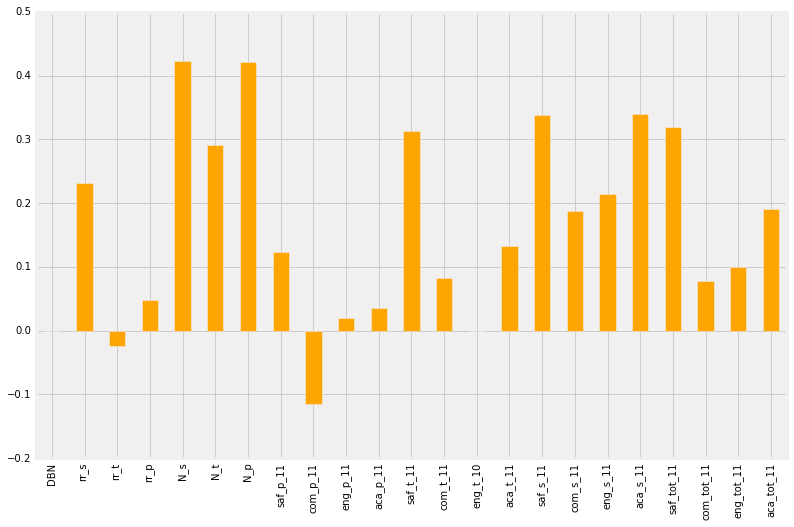

In [46]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar(figsize=(12,8), color = 'orange')

Há altas correlações entre N_s, N_t, N_p e sat_score. Uma vez que estas colunas estão correlacionadas com total_enrollment, faz sentido que as correlações sejam altas.

É interessante notar que o rr_s (porcentagem de respostas de estudantes), ou seja, a porcentagem de estudantes que completaram a pesquisa, se correlaciona com sat_score. Isso faz sentido, já que é provável que estudantes que são mais propensos a preencher pesquisas também se saem melhor academicamente.

A percepção de estudantes e professores acerca da segurança (saf_t_11 e saf_s_11) se correlaciona com sat_score. Isso faz sentido, já que é difícil ensinar ou aprender em um ambiente sem segurança.

A última correlação interessante é a aca_s_11, que indica como o aluno percebe os padrões acadêmicos. Esta se correlaciona com sat_score. No entanto, isso não é verdade para a aca_t_11 (como os professores percebem os padrões acadêmicos) ou para a aca_p_11 (como os pais percebem os padrões acadêmicos).

### Visualizando dados de matrículas

Algo que não foi uma surpresa foi o fato de que SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score e sat_score se correlacionam fortemente a sat_score.

Podemos ainda fazer outras observações:

- total_enrollment se correlaciona positiva e fortemente com sat_score, o que gera uma certa surpresa, já que espera-se que escolas menores, mais focadas no aluno, teriam notas mais altas. No entanto, parece o contrário - escolas maiores tendem a se sair melhor no SAT.
    - Outras colunas, que servem como indicadores de matrículas, como total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS também se correlacionam.
- A porcentagem de mulheres em uma escola (female_per) e o número de mulheres (female_num) se correlacionam positivamente com a pontuação do SAT, enquanto a porcentagem de homens (male_per) e o número de machos (male_num) se correlacionam negativamente. Isto indica que as mulheres se saem melhor no SAT do que os homens.
- O alto nível de segurança dos professores e alunos na escola (saf_t_11, e saf_s_11) se correlaciona com sat_score.
- O alto nível de qualificação acadêmica dos alunos (aca_s_11) se correlaciona com sat_score, mas isso não se aplica a professores e pais (aca_p_11 e aca_t_11).
- Existe uma desigualdade racial significativa nos resultados do SAT (branco_por, asiático_por, preto_por, hispânico_por).
- A porcentagem de alunos de inglês na escola (ell_percent, frl_percent) se correlaciona forte e negativamente com os resultados do SAT.

Uma vez que as matrículas parecem ter uma correlação tão forte, vamos fazer um gráfico de dispersão para visualizar total_enrollment vs. sat_score. Cada ponto no scatterplot representará uma escola de nível secundário, assim poderemos ver se há algum padrão interessante.

Podemos plotar colunas em um Dataframe usando o assistente de plotagem. Podemos utilizar de maneira fácil diferentes tipos de plotagem. Por exemplo df.plot.scatter(x="A", y="b") irá criar um gráfico de dispersão das colunas A e B.

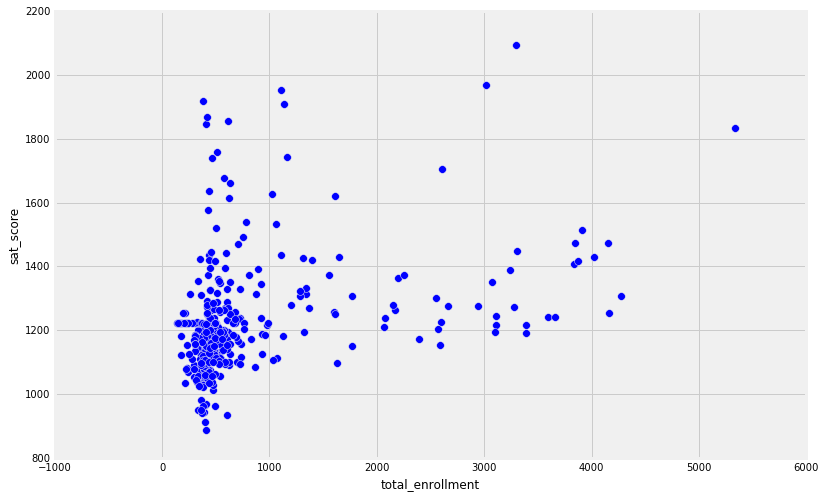

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
combined.plot.scatter(x='total_enrollment', y='sat_score', figsize = (12, 8), s = 60, color ='blue')
plt.show()

### Explorando dados de escolas com baixa pontuação no SAT e matrículas

Olhando para o gráfico que acabamos de gerar, não parece haver uma correlação extremamente forte entre o sat_score e total_enrollment. Se houvesse uma correlação muito forte, esperaríamos que todos os pontos estivessem dispostos em uma linha. Ao invés disso, há um grande aglomerado de escolas, depois algumas poucas escolas que seguem em 3 direções diferentes.

No entanto, há um conjunto interessante de pontos na parte inferior esquerda onde o total_enrollment e sat_score são ambos baixos. Este cluster pode ser o que está fazendo com que o nosso valor r seja tão alto. Vale a pena extrair os nomes das escolas deste cluster, para que possamos fazer uma pesquisa mais profunda sobre elas.

In [48]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]
print(low_enrollment["School Name"])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


### Visualizando dados de porcentagem de aprendizagem de línguas

A partir de nossa pesquisa acima, descobrimos que a maioria das escolas de ensino médio com baixa quantidade de total de matrículas e baixa pontuação no SAT são na verdade escolas com uma alta porcentagem de alunos estudantes da língua inglesa (não possuem o inglês como língua materna). Isto indica que é na verdade ell_percent que se correlaciona fortemente com o sat_score ao invés do total_de_ matriculados. Para explorar mais esta relação, vamos traçar o ell_percent vs sat_score.

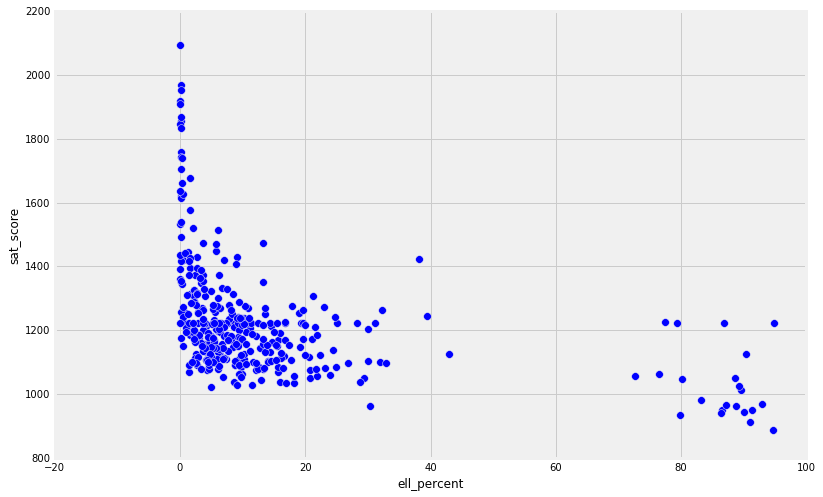

In [49]:
combined.plot.scatter(x='ell_percent', y='sat_score', figsize = (12,8), s=60, color = 'Blue')
plt.show()

### Mapeando as escolas

Parece que o ell_percent se correlaciona mais fortemente com sat_score, pois o gráfico de dispersão é mais linear. No entanto, ainda há o cluster muito alto no ell_percent muito vs. sat_score baixo, que repersenta o mesmo grupo de escolas secundárias internacionais que investigamos anteriormente.

A fim de explorar esta relação, vamos mapear o ell_percent por distrito escolar, para que possamos ver mais facilmente quais partes da cidade têm muitos estudantes da língua inglesa.

Para fazer isso, precisamos ser capazes de criar mapas. Anteriormente, extraímos as coordenadas de todas as escolas e as armazenamos nas colunas lat e lon. Isso nos permitirá plotar todas as escolas em um mapa dos EUA, com enfoque na cidade de Nova York.

O código acima irá criar um gráfico, centrado na cidade de Nova York (llcrnrlat, urcrnrlat, llcrnrlon e urcrnrlon definem a área que é mostrada), e irá desenhar linhas costeiras e rios característicos destas áreas.

Agora, tudo que precisamos fazer é converter nossas coordenadas lat e lon em coordenadas x e y para que possamos plotá-las no topo do mapa. Isto nos mostrará onde estão localizadas todas as escolas do nosso conjunto de dados.

Para traçar coordenadas usando o basemap, é necessário:

- Converter as séries que contem os dados de latitude e longitude para listas, utilizando o método tolist
- Criar um gráfico de dispersão utilizando as longitudes e latitudes com o método de dispersão no objeto basemap
- Exibir o resultado, por meio do método show

Além disso, precisamos nos assegurar de passar alguns argumentos (palavras-chave) ao método de dispersão:

- s: isso afeta o tamanho do ponto que representa cada escola no mapa.
- zorder: isso afeta onde os pontos que representam as escolas serão desenhados no eixo z. Se a fixarmos em 2, os pontos serão desenhados no topo da área continental, que é onde os queremos.
- latlon: este é um parâmetro booleano que especifica se estamos passando as informações em coordenadas de latitude e longitude ao invés de coordenadas x/y do gráfico.

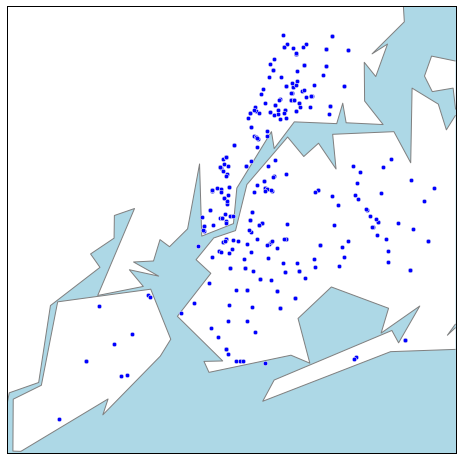

In [50]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(8,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, marker = '.')

plt.show()

### Visualizando estatísticas

Pelo mapa acima, podemos ver que há uma maior densidade de escolas em Manhattan (o topo do mapa) e menor densidade no Brooklyn, Bronx, Queens e Staten Island.

Agora que podemos enxergar as posições das escolas, podemos começar a exibir informações significativas nos mapas, como a porcentagem de alunos de inglês por área.

Podemos sombrear cada ponto do gráfico de dispersão, utilizando o argumento palavra-chave c dentro do método utilizado para a geração do gráfico de dispersão. O argumento palavra-chave c aceitará uma sequência de números, e sombreará os pontos correspondentes aos números mais baixos ou números mais altos de forma diferente.

Qualquer sequência numéricas que passarmos para o argumento palavra-chave c será convertida em um intervalo de 0 a 1. Estes valores serão então mapeados em um mapa colorido. O Matplotlib tem vários colormaps padrão. No nosso caso, vamos usar o mapa de cores do verão, que é composto por pontos verdes quando o número associado é baixo e amarelos quando o número é alto.

Por exemplo, digamos que plotemos ell_percent por escola. Se passarmos no argumento palavra-chave c=combined["ell_percent"], então qualquer escola com um alto ell_percent será sombreada de amarelo, e qualquer escola com um baixo ell_percent será sombreada de verde. Nós podemos especificar um colormap passando o argumento  palavra-chave cmap ao método gráfico de dispersão.

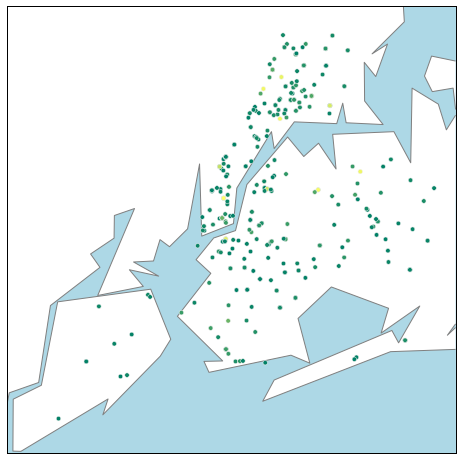

In [51]:
plt.figure(figsize=(8,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, marker = '.', c=combined["ell_percent"], cmap="summer")
plt.show()

## Cálculos estatísticos a nível distrital 

Infelizmente, devido ao número de escolas, é difícil interpretar o mapa que fizemos acima. Parece que o centro de Manhattan e partes de Queens têm um percentual maior, mas não é possível termos certeza disso. Uma maneira de facilitar a leitura de estatísticas muito granulares é agregá-las. Neste caso, podemos agregar com base no distrito, o que nos permitirá plotar o el_percent distrito por distrito, ao invés de escola por escola.

In [53]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


### Plotando valores Ell_percent por distrito

Agora que calculamos a média de todas as colunas, podemos traçar o gráfico por distrito. Não só encontramos a média de ell_percent, como também calculamos a média das colunas lon e lat, o que nos dará as coordenadas referentes ao centro de cada distrito.

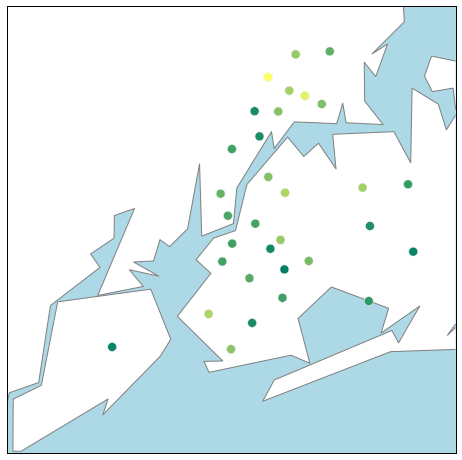

In [54]:
plt.figure(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='white',lake_color='#85A6D9')


longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")
plt.show()

### Segurança e pontuação no SAT

Vamos investigar valores referentes a Segurança.

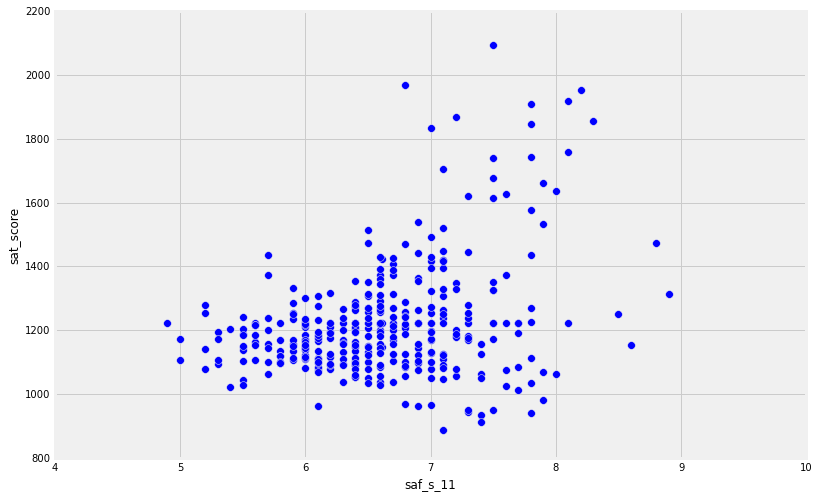

In [55]:
combined.plot.scatter("saf_s_11", "sat_score", figsize = (12,8), s =60, color = 'blue')

Parece haver uma correlação entre os resultados do SAT e a segurança, embora não seja algo tão forte assim. Parece que existem algumas escolas com pontuações extremamente altas no SAT e com altas pontuações de segurança. Há algumas escolas com baixa pontuação em segurança e baixa pontuação no SAT. Nenhuma escola com pontuação de segurança inferior a 6,5 tem pontuação média de SAT superior a 1500 ou mais.

### Plotando dados de Segurança

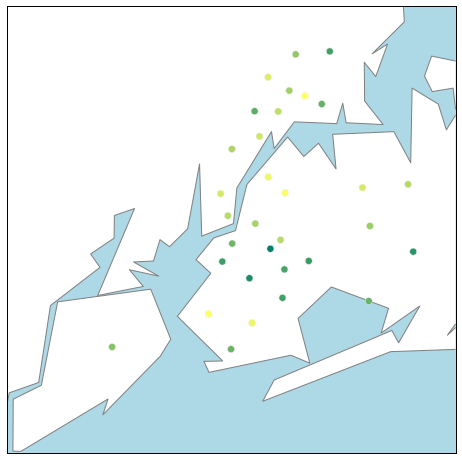

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)


plt.figure(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

Parece que o Upper Manhattan e partes do Queens e do Bronx tendem a ter pontuações de segurança mais baixas, enquanto o Brooklyn tem pontuações de segurança altas.

### Diferenças raciais relacionadas a pontuação do SAT 

Existem algumas colunas que indicam o percentual de cada raça em uma determinada escola:

- white_per
- asian_per
- black_per
- hispanic_per

Traçando as correlações entre essas colunas e o sat_score, podemos ver se existem diferenças raciais no desempenho do SAT.

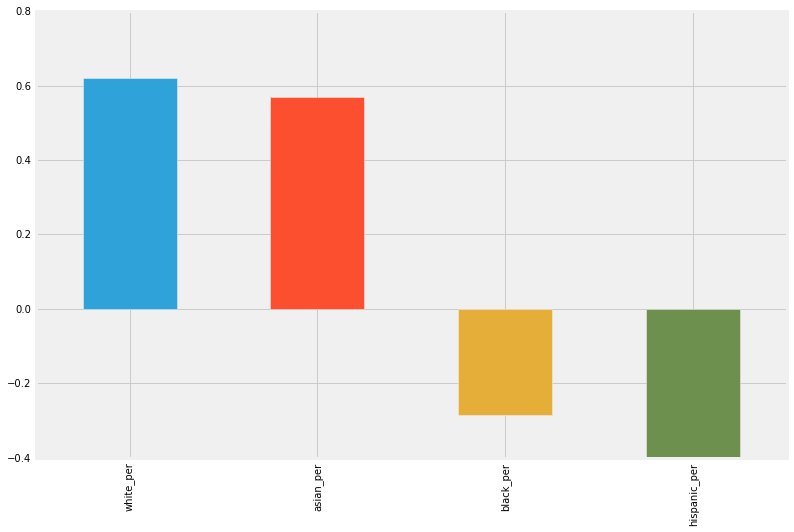

In [58]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar(figsize = (12,8))

Parece que uma porcentagem maior de alunos brancos ou asiáticos em uma escola se correlaciona positivamente com a pontuação sentada, enquanto uma porcentagem maior de alunos negros ou hispânicos se correlaciona negativamente com a pontuação sentada. Isto pode ser devido à falta de financiamento para escolas em certas áreas, que têm maior probabilidade de ter uma porcentagem maior de alunos negros ou hispânicos.

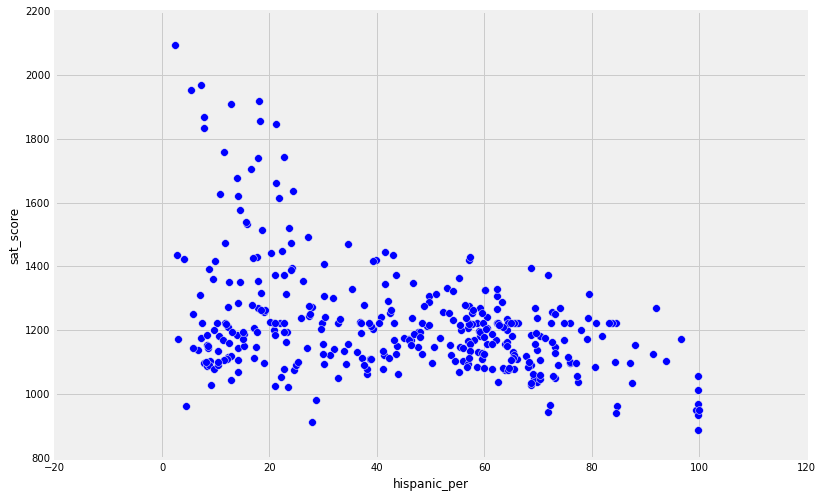

In [59]:
combined.plot.scatter("hispanic_per", "sat_score", figsize=(12,8), s =60, color = 'Blue')

In [60]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [61]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Muitas das escolas acima parecem ser escolas especializadas em ciência e tecnologia que recebem financiamento extra, e só admitem alunos que passam no vestibular. Isso não explica o baixo índice de hispanismo, mas explica porque seus alunos tendem a se sair melhor no SAT - eles são alunos de toda Nova York que se saíram bem em um teste padronizado.

### Diferenças de gênero nas pontuações do SAT

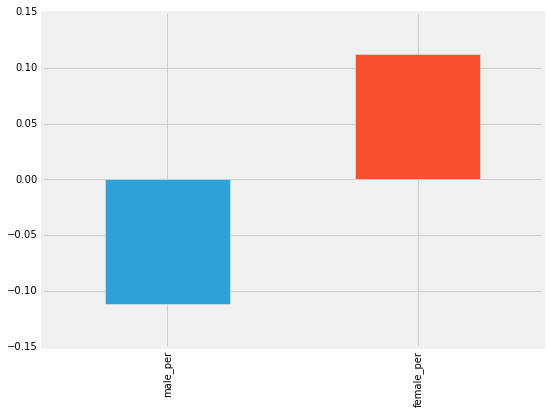

In [62]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar(figsize = (8, 6))

No gráfico acima, podemos ver que uma alta porcentagem de fêmeas em uma escola se correlaciona positivamente com o resultado do SAT, enquanto que uma alta porcentagem de machos em uma escola se correlaciona negativamente com o resultado do SAT. Nenhuma das duas correlações é extremamente forte.

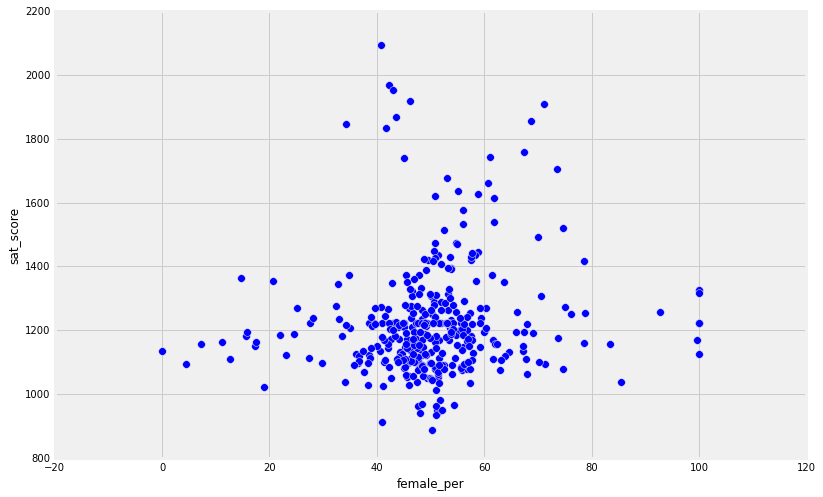

In [63]:
combined.plot.scatter("female_per", "sat_score", figsize = (12, 8), s = 60)

Com base no scatterplot, não parece haver nenhuma correlação real entre o sat_score e o fem_per. Entretanto, há um grupo de escolas com uma alta porcentagem de fêmeas (60 a 80), e altas pontuações no SAT.

In [64]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Essas escolas parecem ser escolas de artes liberais muito seletivas, com altos padrões acadêmicos.

### Pontuações em exames AP vs. pontuações no SAT

In the US, the Advanced Placement, or AP, exams, are exams that high schoolers take in order to gain college credit. AP exams can be taken in many different subjects, and passing the AP exam means that colleges may grant you credits.

It makes sense that the number of students who took the AP exam in a school and SAT scores would be highly correlated, and let's dig into the relationship. Since total_enrollment is highly correlated with sat_score, we don't want to bias our results, so we'll instead look at the percentage of students in each school who took at least one AP exam.

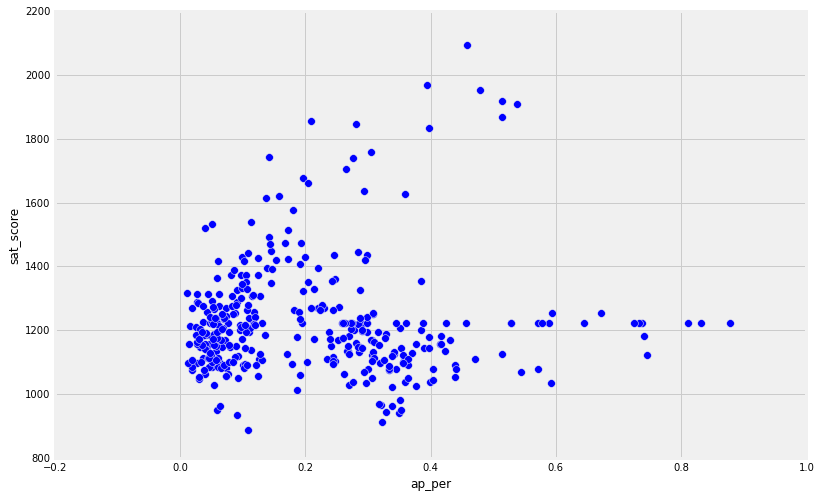

In [65]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score', figsize = (12, 8), s = 60)

Parece haver uma relação entre o percentual de alunos de uma escola que prestam o exame AP e sua média de aproveitamento no SAT. Não é uma correlação extremamente forte, no entanto.